In [1]:
from neo4j import GraphDatabase

In [16]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(
    uri,
    auth=("neo4j", "qwerty123")
)

In [17]:
def print_greeting(tx, message):
    result = tx.run("CREATE (a:Greeting) "
                    "SET a.message = $message "
                    "RETURN a.message + ', from node ' + id(a)", message=message)
    print(result.single()[0])

In [18]:
with driver.session() as session:
    session.execute_write(print_greeting, "hello, world")

hello, world, from node 0


In [23]:
def delete_all(tx):
    tx.run("MATCH (n) DETACH DELETE n")

In [25]:
with driver.session() as session:
    session.write_transaction(delete_all)

/var/folders/q4/f10ygngd6fs87_lchvr0d8040000gn/T/ipykernel_10727/1267636488.py:2: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(delete_all)


In [19]:
from torch_geometric.datasets import KarateClub

In [20]:
dataset = KarateClub()

In [38]:
data = dataset[0]
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [39]:
def write_data_to_neo4j(tx, edges):
    # Create nodes
    for i in range(data.num_nodes):
        tx.run("CREATE (:Person {id: $id})", id=i)
    
    # Create edges
    for i, j in edges:
        tx.run("""
        MATCH (a:Person {id: $i}), (b:Person {id: $j})
        CREATE (a)-[:FRIEND]->(b)
        """, i=i, j=j)

In [40]:
edges = list(zip(*data.edge_index.tolist()))

In [41]:
with driver.session() as session:
    session.write_transaction(write_data_to_neo4j, edges)

/var/folders/q4/f10ygngd6fs87_lchvr0d8040000gn/T/ipykernel_10727/1413840066.py:2: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(write_data_to_neo4j, edges)


In [42]:
import networkx as nx
import matplotlib.pyplot as plt

In [43]:
G = nx.Graph()

In [44]:
def add_edges(tx):
    result = tx.run("MATCH (n:Person)-[r:FRIEND]->(m:Person) RETURN n.id, m.id")
    for record in result:
        G.add_edge(record["n.id"], record["m.id"])

In [45]:
with driver.session() as session:
    session.read_transaction(add_edges)

/var/folders/q4/f10ygngd6fs87_lchvr0d8040000gn/T/ipykernel_10727/2878722072.py:2: DeprecationWarning: read_transaction has been renamed to execute_read
  session.read_transaction(add_edges)


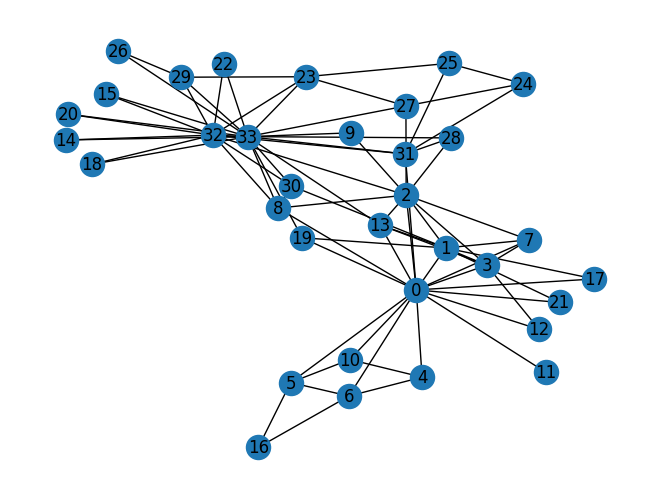

In [46]:
nx.draw(G, with_labels=True)
plt.show()